## Read the Dataset

In [1]:
import numpy as np

Directory = "D:/S3_project/S Picker/Cooked_Dataset/Dataset100Hz/signal_dataset_20F_100Hz_Scaled_01.npy"
signal_dataset = np.load(Directory)

Directory = "D:/S3_project/S Picker/Cooked_Dataset/Dataset100Hz/label_dataset_20F_100Hz_Scaled_01.npy"
label_dataset = np.load(Directory)

In [2]:
#Check the shape
print(signal_dataset.shape)
print(label_dataset.shape)

(748405, 100, 6)
(748405,)


## Prerocess

Access several Attributes in Trace and Constructing Moving Window

In [3]:
#Access the attribute of period and total Samples
Period = 0.01
train_samples = signal_dataset.shape[0]
df = 1/Period
#First Calculation
train_windows_seconds = 1 #Try training window at 4 seconds
train_windows_samples = int(train_windows_seconds / Period)
moving_windows_seconds = 0.04 #Try overlapping at 0,05second
moving_windows_samples = int(moving_windows_seconds/Period)
print("The period of this data is : ", Period, " Seconds")
print("Try the Training Windows for each ", train_windows_seconds, " Seconds")
print("So, the Training Windows for this data is for each ", train_windows_samples, " Samples")
print("Also, the Moving Windows for this data is for each ", moving_windows_samples, " Samples")
print("It means that there will be ", train_samples, " Training samples from this traces")

The period of this data is :  0.01  Seconds
Try the Training Windows for each  1  Seconds
So, the Training Windows for this data is for each  100  Samples
Also, the Moving Windows for this data is for each  4  Samples
It means that there will be  748405  Training samples from this traces


Check the Label_Dataset

In [4]:
print(label_dataset.shape)
List_Found = (np.where((label_dataset) == 1))[0]
print(List_Found.shape)
List_Found=None

(748405,)
(332733,)


In [5]:
print(signal_dataset.shape)
print(label_dataset.shape)

(748405, 100, 6)
(748405,)


Split the training and test Data

In [6]:
#Using SkLearn or Tensorflow to split the data
from sklearn.model_selection import StratifiedShuffleSplit

#Using stratified split (Keeping the precentage of each class)
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(signal_dataset, label_dataset):
    train_signal, test_signal = signal_dataset[train_index], signal_dataset[test_index]
    train_labels, test_labels = label_dataset[train_index], label_dataset[test_index]

Check The Splitting

In [7]:
print(train_signal.shape)
print(test_signal.shape)
print(train_labels.shape)
print(test_labels.shape)

(598724, 100, 6)
(149681, 100, 6)
(598724,)
(149681,)


## Creating Deep Neural Network Model

In [8]:
#Creating the model for deep learning
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

#We will use a Model from Paper Microseismic 2020 (CNN Explainable)
#Pooling is max pooling with 2x2 window

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense,Flatten


model = Sequential()
#Here we will have 32 filters using a 5 window for convolutional layer 
#2 window for the pooling layer
#Input Shape will be train_windows and 3 means the channel of the signals

#height = 160F (Time sample)
#Width = 6 (Channels)

model.add(Conv2D(32, (1,4), 
          activation='relu',  padding='same', input_shape=(1, train_windows_samples, 6)))
model.add(Dropout(0.2))
model.add(Conv2D(32, (1,6), padding = 'same', activation="relu", input_shape=(1, train_windows_samples, 6)))
model.add(Dropout(0.2))
#model.add(layers.MaxPooling2D((2, 1)))
model.add(Flatten())
model.add(Dense(16, kernel_initializer='glorot_uniform', activation='relu'))
model.add(Dropout(0.2))
#2 means just two outputs, between noise class or P-Wave Class
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1, 100, 32)        800       
                                                                 
 dropout (Dropout)           (None, 1, 100, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 100, 32)        6176      
                                                                 
 dropout_1 (Dropout)         (None, 1, 100, 32)        0         
                                                                 
 flatten (Flatten)           (None, 3200)              0         
                                                                 
 dense (Dense)               (None, 16)                51216     
                                                                 
 dropout_2 (Dropout)         (None, 16)                0

## Compile And Training the Model

In [9]:
# Set up checkpoint to save models regularly while training
filepath = "D:/S3_project/S Picker/forconference/weights_with_pool_16dense.best.hdf5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

#If there is no improvement on val_lost by 10 epochs, it will be stopped!
callback_list = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15), checkpoint_callback]

orig_train_shape = train_signal.shape
orig_test_shape = test_signal.shape

#reshapes it so we have 3D Tensor
train_signal = train_signal.reshape((orig_train_shape[0], 1, orig_train_shape[1], orig_train_shape[2]))

#reshapes it so we have 3D Tensor
test_signal = test_signal.reshape((orig_test_shape[0], 1, orig_test_shape[1], orig_test_shape[2]))

#Compile the model 
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy','Precision','Recall','AUC'])

In [10]:
#Train the model with validation, return from this section is the final model from training
history = model.fit(train_signal, train_labels,
          batch_size=64,
          callbacks=callback_list, #Learning rate scheduler
          validation_split=0.2, #To split the training more to validation
          epochs=400,
          verbose=1)

Epoch 1/400
7485/7485 [==============================] - ETA: 0s - loss: 0.2373 - accuracy: 0.9079 - precision: 0.9086 - recall: 0.8815 - auc: 0.9649
Epoch 1: val_accuracy improved from -inf to 0.93243, saving model to D:/S3_project/S Picker/forconference\weights_with_pool_16dense.best.hdf5
7485/7485 [==============================] - 64s 8ms/step - loss: 0.2373 - accuracy: 0.9079 - precision: 0.9086 - recall: 0.8815 - auc: 0.9649 - val_loss: 0.1718 - val_accuracy: 0.9324 - val_precision: 0.9294 - val_recall: 0.9178 - val_auc: 0.9815
Epoch 2/400
7478/7485 [============================>.] - ETA: 0s - loss: 0.1897 - accuracy: 0.9270 - precision: 0.9268 - recall: 0.9076 - auc: 0.9775
Epoch 2: val_accuracy improved from 0.93243 to 0.93985, saving model to D:/S3_project/S Picker/forconference\weights_with_pool_16dense.best.hdf5
7485/7485 [==============================] - 59s 8ms/step - loss: 0.1897 - accuracy: 0.9270 - precision: 0.9268 - recall: 0.9076 - auc: 0.9775 - val_loss: 0.1553 - v

Epoch 17/400
7479/7485 [============================>.] - ETA: 0s - loss: 0.1425 - accuracy: 0.9450 - precision: 0.9325 - recall: 0.9447 - auc: 0.9872
Epoch 17: val_accuracy improved from 0.96093 to 0.96106, saving model to D:/S3_project/S Picker/forconference\weights_with_pool_16dense.best.hdf5
7485/7485 [==============================] - 60s 8ms/step - loss: 0.1425 - accuracy: 0.9450 - precision: 0.9325 - recall: 0.9447 - auc: 0.9872 - val_loss: 0.1105 - val_accuracy: 0.9611 - val_precision: 0.9495 - val_recall: 0.9637 - val_auc: 0.9926
Epoch 18/400
7483/7485 [============================>.] - ETA: 0s - loss: 0.1423 - accuracy: 0.9452 - precision: 0.9323 - recall: 0.9453 - auc: 0.9873
Epoch 18: val_accuracy did not improve from 0.96106
7485/7485 [==============================] - 61s 8ms/step - loss: 0.1424 - accuracy: 0.9452 - precision: 0.9323 - recall: 0.9453 - auc: 0.9872 - val_loss: 0.1063 - val_accuracy: 0.9606 - val_precision: 0.9577 - val_recall: 0.9534 - val_auc: 0.9928
Epoc

7483/7485 [============================>.] - ETA: 0s - loss: 0.1345 - accuracy: 0.9486 - precision: 0.9347 - recall: 0.9509 - auc: 0.9886
Epoch 33: val_accuracy did not improve from 0.96541
7485/7485 [==============================] - 56s 8ms/step - loss: 0.1345 - accuracy: 0.9486 - precision: 0.9347 - recall: 0.9510 - auc: 0.9886 - val_loss: 0.1007 - val_accuracy: 0.9646 - val_precision: 0.9505 - val_recall: 0.9709 - val_auc: 0.9935
Epoch 34/400
7484/7485 [============================>.] - ETA: 0s - loss: 0.1345 - accuracy: 0.9484 - precision: 0.9341 - recall: 0.9511 - auc: 0.9885
Epoch 34: val_accuracy improved from 0.96541 to 0.96614, saving model to D:/S3_project/S Picker/forconference\weights_with_pool_16dense.best.hdf5
7485/7485 [==============================] - 60s 8ms/step - loss: 0.1345 - accuracy: 0.9484 - precision: 0.9341 - recall: 0.9511 - auc: 0.9885 - val_loss: 0.0965 - val_accuracy: 0.9661 - val_precision: 0.9542 - val_recall: 0.9704 - val_auc: 0.9938
Epoch 35/400
7485

7479/7485 [============================>.] - ETA: 0s - loss: 0.1317 - accuracy: 0.9499 - precision: 0.9353 - recall: 0.9534 - auc: 0.9890
Epoch 50: val_accuracy did not improve from 0.96797
7485/7485 [==============================] - 60s 8ms/step - loss: 0.1317 - accuracy: 0.9499 - precision: 0.9353 - recall: 0.9534 - auc: 0.9890 - val_loss: 0.0958 - val_accuracy: 0.9677 - val_precision: 0.9532 - val_recall: 0.9752 - val_auc: 0.9940
Epoch 51/400
7480/7485 [============================>.] - ETA: 0s - loss: 0.1306 - accuracy: 0.9501 - precision: 0.9355 - recall: 0.9536 - auc: 0.9892
Epoch 51: val_accuracy did not improve from 0.96797
7485/7485 [==============================] - 61s 8ms/step - loss: 0.1306 - accuracy: 0.9501 - precision: 0.9355 - recall: 0.9536 - auc: 0.9892 - val_loss: 0.0932 - val_accuracy: 0.9672 - val_precision: 0.9510 - val_recall: 0.9765 - val_auc: 0.9942
Epoch 52/400
7479/7485 [============================>.] - ETA: 0s - loss: 0.1315 - accuracy: 0.9503 - precision

Epoch 68/400
7480/7485 [============================>.] - ETA: 0s - loss: 0.1286 - accuracy: 0.9512 - precision: 0.9357 - recall: 0.9559 - auc: 0.9894
Epoch 68: val_accuracy did not improve from 0.96863
7485/7485 [==============================] - 61s 8ms/step - loss: 0.1286 - accuracy: 0.9512 - precision: 0.9357 - recall: 0.9559 - auc: 0.9894 - val_loss: 0.0952 - val_accuracy: 0.9671 - val_precision: 0.9611 - val_recall: 0.9652 - val_auc: 0.9942
Epoch 69/400
7479/7485 [============================>.] - ETA: 0s - loss: 0.1285 - accuracy: 0.9511 - precision: 0.9358 - recall: 0.9555 - auc: 0.9895
Epoch 69: val_accuracy did not improve from 0.96863
7485/7485 [==============================] - 61s 8ms/step - loss: 0.1285 - accuracy: 0.9511 - precision: 0.9358 - recall: 0.9555 - auc: 0.9895 - val_loss: 0.0963 - val_accuracy: 0.9668 - val_precision: 0.9473 - val_recall: 0.9799 - val_auc: 0.9942
Epoch 70/400
7480/7485 [============================>.] - ETA: 0s - loss: 0.1289 - accuracy: 0.951

7479/7485 [============================>.] - ETA: 0s - loss: 0.1275 - accuracy: 0.9520 - precision: 0.9363 - recall: 0.9573 - auc: 0.9896
Epoch 85: val_accuracy did not improve from 0.96987
7485/7485 [==============================] - 58s 8ms/step - loss: 0.1275 - accuracy: 0.9520 - precision: 0.9363 - recall: 0.9573 - auc: 0.9896 - val_loss: 0.0964 - val_accuracy: 0.9660 - val_precision: 0.9704 - val_recall: 0.9525 - val_auc: 0.9944
Epoch 86/400
7479/7485 [============================>.] - ETA: 0s - loss: 0.1283 - accuracy: 0.9516 - precision: 0.9363 - recall: 0.9561 - auc: 0.9895
Epoch 86: val_accuracy did not improve from 0.96987
7485/7485 [==============================] - 61s 8ms/step - loss: 0.1282 - accuracy: 0.9516 - precision: 0.9363 - recall: 0.9561 - auc: 0.9895 - val_loss: 0.0901 - val_accuracy: 0.9690 - val_precision: 0.9575 - val_recall: 0.9736 - val_auc: 0.9945
Epoch 87/400
7478/7485 [============================>.] - ETA: 0s - loss: 0.1282 - accuracy: 0.9512 - precision

Save the model

In [11]:
Directory = "D:/S3_project/S Picker/forconference/S_Detector1_16dense.h5"
model.save(Directory) 

## Evaluate the model

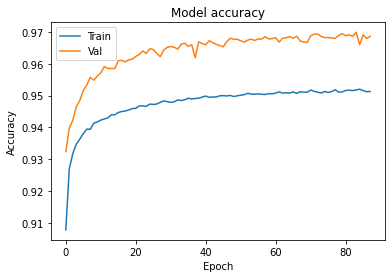

In [12]:
#Visualize the history
#Visualize the models accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

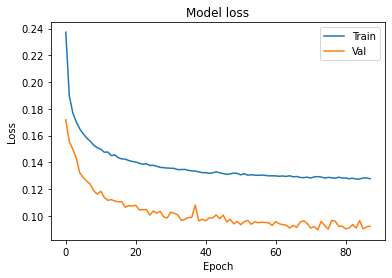

In [13]:
#Visualize the models loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

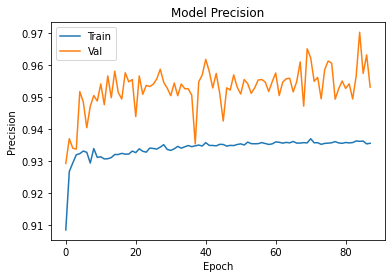

In [14]:
#Visualize the history
#Visualize the models Precision
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

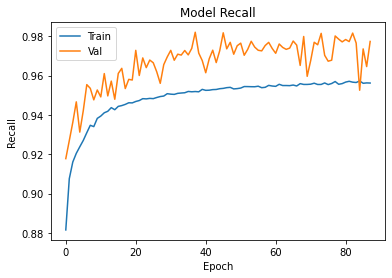

In [15]:
#Visualize the history
#Visualize the models recall
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [16]:
test_loss, test_acc, test_precision, test_recall, test_auc = model.evaluate(test_signal, test_labels, verbose = 2)

print('Test accuracy:', test_acc)

4678/4678 - 20s - loss: 0.0924 - accuracy: 0.9687 - precision: 0.9539 - recall: 0.9768 - auc: 0.9943 - 20s/epoch - 4ms/step
Test accuracy: 0.968666672706604
